In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
data_path = "data/crs_final_df_kor.csv"
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0
random.seed(SEED)
np.random.seed(SEED)


In [ ]:

data1 = pd.read_csv(data_path, header = 0)
data = data1.loc[:,["PurposeCode","LongDescription","ProjectTitle", "ShortDescription"]]
data = data[pd.notnull(data['LongDescription'])] 
data = data[data['LongDescription'].str.len() > 25].reset_index(drop=True).copy()
data['len'] = data['LongDescription'].apply(lambda s : len(s))

## Define CNN model

In [3]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

## Define BiLSTM

In [4]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

## With minimum requirement
- Over 100 classification

In [5]:
count_df = data[['PurposeCode','LongDescription']].groupby('PurposeCode').aggregate({'LongDescription':'count'}).reset_index().sort_values('LongDescription',ascending=False)
target_code = count_df[count_df['LongDescription']>100]['PurposeCode'].values
def condition_parser(x):
    if x in target_code:
        return x
    else:
        return "OTHER"
    
data['PurposeCode'] = data['PurposeCode'].apply(lambda x: condition_parser(x))  
data['PurposeCode'] = data['PurposeCode'].map(str)
data = data[data['PurposeCode']!='OTHER'] 

### Preprocessing

In [6]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")
# lower the text
data["LongDescription"] = data["LongDescription"].apply(lambda x: x.lower())

# Clean the text
data["LongDescription"] = data["LongDescription"].apply(lambda x: clean_text(x))

# Clean numbers
data["LongDescription"] = data["LongDescription"].apply(lambda x: clean_numbers(x))

# Clean Contractions
data["LongDescription"] = data["LongDescription"].apply(lambda x: replace_contractions(x))
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['LongDescription'], data['PurposeCode'],
                                                    stratify=data['PurposeCode'], 
                                                    test_size=0.25)
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

Train shape :  (45405,)
Test shape :  (15135,)


### Load Global Vectors for Word Representation (GloVe)

In [ ]:
def load_glove(word_index):
    # kaggle.com/datasets/takuok/glove840b300dtxt/versions/1?resource=download
    glove_embedding_path = 'data/glove.840B.300d.txt'
    EMBEDDING_FILE = glove_embedding_path
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix 
if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

### Run CNN

In [8]:
n_epochs = 10
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_))) 
    # keep/store predictions
    with torch.no_grad(): # You should use no_grad session when you evaluate the model. (It is much faster!)
        for i, (x_batch, y_batch) in enumerate(valid_loader): 
            y_pred = model(x_batch).detach()
            avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
            val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred, dim=1).cpu().numpy()
    
    # Check Accuracy
    pred_y = val_preds.argmax(axis=1) 
    import sklearn.metrics
    # val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    f1 = sklearn.metrics.f1_score(y_true=test_y,y_pred=pred_y,average='macro')
    auc = sklearn.metrics.roc_auc_score(y_true=test_y,y_score=val_preds,multi_class='ovr')
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    # #top k function
    # prob, pred = val_preds.topk(3)
    # le.inverse_transform(pred)

    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f} \t f1={:.4f} \t auc={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, f1, auc ,elapsed_time))

Epoch 1/10 	 loss=1433.3867 	 val_loss=922.8392  	 val_acc=0.5845 	 f1=0.3044 	 auc=0.9604 	 time=10.99s
Epoch 2/10 	 loss=734.5078 	 val_loss=564.8492  	 val_acc=0.7310 	 f1=0.5706 	 auc=0.9856 	 time=11.12s
Epoch 3/10 	 loss=510.5536 	 val_loss=432.7177  	 val_acc=0.7841 	 f1=0.6903 	 auc=0.9907 	 time=10.73s
Epoch 4/10 	 loss=409.0862 	 val_loss=365.1468  	 val_acc=0.8175 	 f1=0.7534 	 auc=0.9930 	 time=11.74s
Epoch 5/10 	 loss=346.5550 	 val_loss=323.2838  	 val_acc=0.8344 	 f1=0.7819 	 auc=0.9943 	 time=10.57s
Epoch 6/10 	 loss=306.4895 	 val_loss=296.8901  	 val_acc=0.8452 	 f1=0.7923 	 auc=0.9950 	 time=10.19s
Epoch 7/10 	 loss=275.9480 	 val_loss=276.8849  	 val_acc=0.8548 	 f1=0.8164 	 auc=0.9956 	 time=11.61s
Epoch 8/10 	 loss=252.1809 	 val_loss=261.9229  	 val_acc=0.8612 	 f1=0.8235 	 auc=0.9960 	 time=10.40s
Epoch 9/10 	 loss=233.9313 	 val_loss=251.7781  	 val_acc=0.8667 	 f1=0.8347 	 auc=0.9962 	 time=11.67s
Epoch 10/10 	 loss=220.3311 	 val_loss=239.2482  	 val_acc=0.87

In [9]:
torch.save(model,'results/textcnn_model')

In [10]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

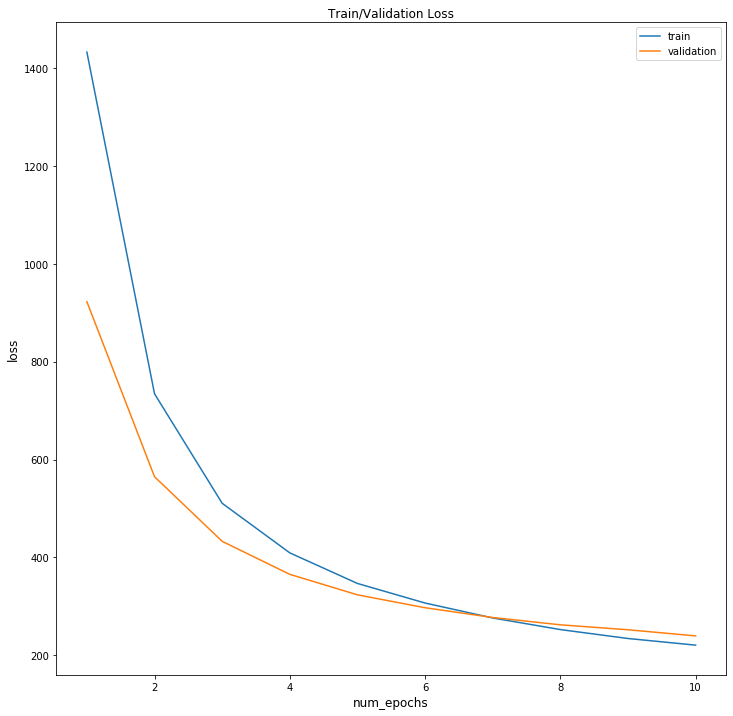

In [11]:
plot_graph(n_epochs)

### Run biLSTM 

In [12]:
n_epochs = 10
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_))) 
    # keep/store predictions
    with torch.no_grad(): # You should use no_grad session when you evaluate the model. (It is much faster!)
        for i, (x_batch, y_batch) in enumerate(valid_loader): 
            y_pred = model(x_batch).detach()
            val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred, dim=1).cpu().numpy()
            avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
            # avg_val_loss += loss.item() / len(train_loader)
    
    # Check Accuracy
    pred_y = val_preds.argmax(axis=1) 
    import sklearn.metrics
    # val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    f1 = sklearn.metrics.f1_score(y_true=test_y,y_pred=pred_y,average='macro')
    auc = sklearn.metrics.roc_auc_score(y_true=test_y,y_score=val_preds,multi_class='ovr')

    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f} \t f1={:.4f} \t auc={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, f1, auc, elapsed_time))

Epoch 1/10 	 loss=1916.7445 	 val_loss=1565.5991  	 val_acc=0.2974 	 f1=0.0406 	 auc=0.8038 	 time=14.68s
Epoch 2/10 	 loss=1369.3306 	 val_loss=1143.3966  	 val_acc=0.4616 	 f1=0.1191 	 auc=0.9245 	 time=16.80s
Epoch 3/10 	 loss=1049.0989 	 val_loss=881.8686  	 val_acc=0.5712 	 f1=0.2193 	 auc=0.9567 	 time=15.51s
Epoch 4/10 	 loss=830.7530 	 val_loss=714.7960  	 val_acc=0.6541 	 f1=0.3509 	 auc=0.9707 	 time=16.03s
Epoch 5/10 	 loss=683.6561 	 val_loss=597.8710  	 val_acc=0.7143 	 f1=0.4789 	 auc=0.9793 	 time=16.70s
Epoch 6/10 	 loss=584.2377 	 val_loss=525.4127  	 val_acc=0.7468 	 f1=0.5455 	 auc=0.9836 	 time=14.79s
Epoch 7/10 	 loss=512.5091 	 val_loss=473.3622  	 val_acc=0.7692 	 f1=0.6015 	 auc=0.9860 	 time=13.63s
Epoch 8/10 	 loss=461.5862 	 val_loss=432.0764  	 val_acc=0.7926 	 f1=0.6568 	 auc=0.9876 	 time=13.51s
Epoch 9/10 	 loss=411.8157 	 val_loss=399.8837  	 val_acc=0.8063 	 f1=0.6924 	 auc=0.9896 	 time=14.69s
Epoch 10/10 	 loss=376.6319 	 val_loss=376.1097  	 val_acc=

In [13]:
torch.save(model,'results/bilstm_model')

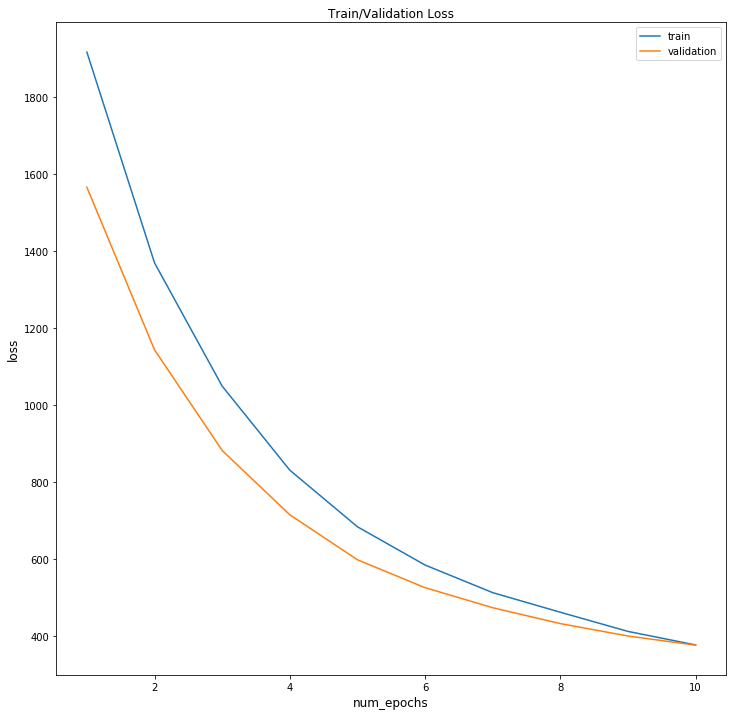

In [14]:
plot_graph(n_epochs)

F1 / AUROC Evaluation

In [ ]:
model.eval()        
avg_val_loss = 0.
val_preds = np.zeros((len(x_cv),len(le.classes_))) 
# keep/store predictions
with torch.no_grad(): # You should use no_grad session when you evaluate the model. (It is much faster!)
    for i, (x_batch, y_batch) in enumerate(valid_loader): 
        y_pred = model(x_batch).detach()
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred, dim=1).cpu().numpy()

# Check Accuracy
pred_y = val_preds.argmax(axis=1) 
import sklearn.metrics
# val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
acc = sklearn.metrics.accuracy_score(y_pred=pred_y,y_true=test_y)
f1 = sklearn.metrics.f1_score(y_true=test_y,y_pred=pred_y,average='macro')
auc = sklearn.metrics.roc_auc_score(y_true=test_y,y_score=val_preds,multi_class='ovr')
prec = sklearn.metrics.precision_score(y_true=test_y,y_pred=pred_y,average='macro')
recall = sklearn.metrics.recall_score(y_true=test_y,y_pred=pred_y,average='macro')
print(acc,f1,auc,prec,recall) 
# 0.8197555335315494 0.7206335487417044 0.9901975804315533 0.7829225534517649 0.6965562367234499